# **Pengenalan Angka Tulisan Tangan Menggunakan Support Vector Machine pada Dataset MNIST**
### Kelompok 5 23F
#### Hani’a Tsabita Fajriah Kansa (23031554073)
#### Mutiara Restu Aulya (23031554113)
#### Tarisa Dwita Abadi (23031554134)


## **Loading Data**

In [ ]:
!pip install scikit-image seaborn

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/PMD/train/'
test_dir = '/content/drive/MyDrive/PMD/test/'

## **Exploratory Data Analysis**

### Cek Kelengkapan Label

In [ ]:
train_labels = sorted(os.listdir(train_dir))
test_labels = sorted(os.listdir(test_dir))

print("Label di train set:", train_labels)
print("Label di test set:", test_labels)

Label di train set: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Label di test set: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Visualisasi Distribusi Label

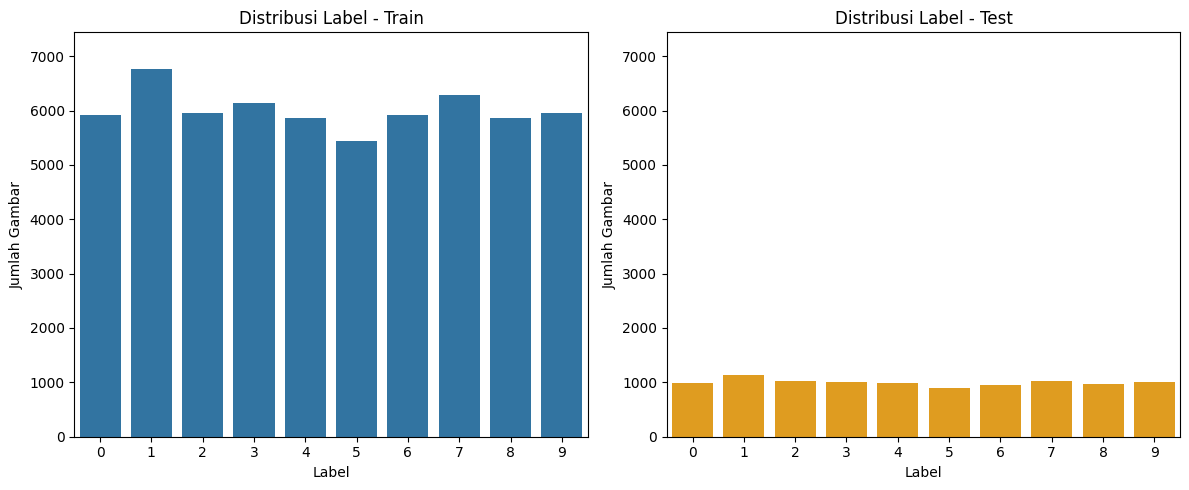

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def count_images_per_label(base_dir):
    counts = {}
    for label in sorted(os.listdir(base_dir)):
        path = os.path.join(base_dir, label)
        if os.path.isdir(path):
            counts[label] = len(os.listdir(path))
    return counts

train_counts = count_images_per_label(train_dir)
test_counts = count_images_per_label(test_dir)

max_count = max(max(train_counts.values()), max(test_counts.values()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Distribusi Label - Train')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.ylim(0, max_count * 1.1)  # kasih sedikit ruang atas

plt.subplot(1, 2, 2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), color='orange')
plt.title('Distribusi Label - Test')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.ylim(0, max_count * 1.1)

plt.tight_layout()
plt.show()



### Visualisasi Distribusi Nilai Pixel

Ukuran gambar unik: {(28, 28)}


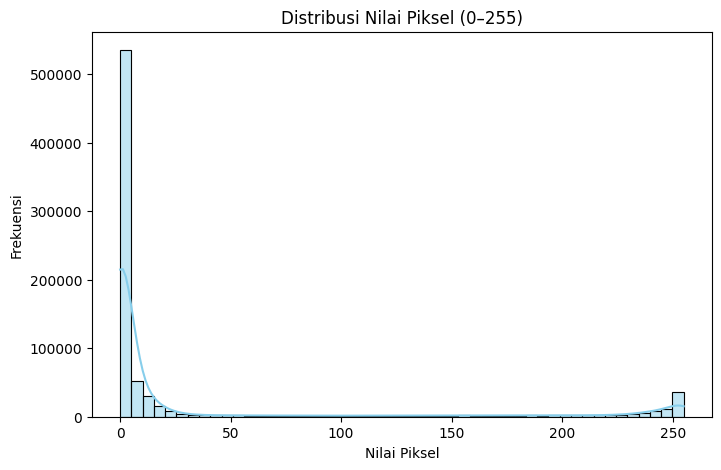

Min: 0, Max: 255
Mean: 35.18, Std: 77.25


In [ ]:
image_sizes = []
pixel_values = []

for label in train_labels:
    folder_path = os.path.join(train_dir, label)
    image_files = os.listdir(folder_path)[:100]  # ambil 100 sample saja
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = Image.open(img_path).convert('L')  # grayscale
        arr = np.array(img)
        image_sizes.append(img.size)
        pixel_values.extend(arr.flatten())

# Ukuran
unique_sizes = set(image_sizes)
print("Ukuran gambar unik:", unique_sizes)

# Nilai piksel
plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, kde=True, color='skyblue')
plt.title('Distribusi Nilai Piksel (0–255)')
plt.xlabel('Nilai Piksel')
plt.ylabel('Frekuensi')
plt.show()

print(f"Min: {np.min(pixel_values)}, Max: {np.max(pixel_values)}")
print(f"Mean: {np.mean(pixel_values):.2f}, Std: {np.std(pixel_values):.2f}")


### Sample Data Train

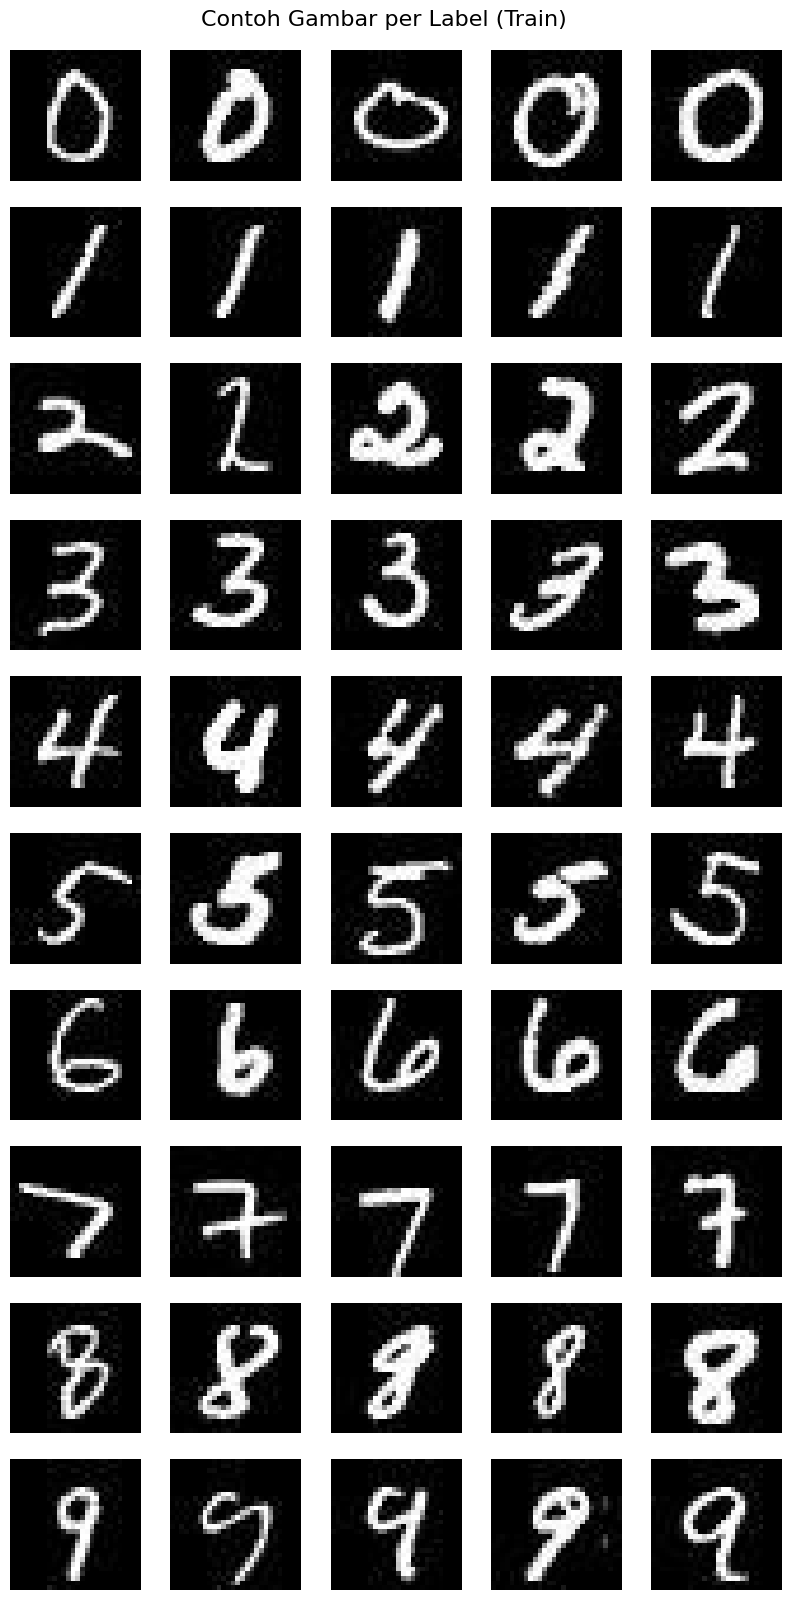

In [ ]:
def show_sample_images(base_dir, labels, samples=5):
    plt.figure(figsize=(samples * 2, len(labels) * 2))
    for i, label in enumerate(labels):
        img_files = os.listdir(os.path.join(base_dir, label))[:samples]
        for j, file in enumerate(img_files):
            img_path = os.path.join(base_dir, label, file)
            img = Image.open(img_path)
            plt.subplot(len(labels), samples, i * samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.ylabel(label, fontsize=12)
    plt.suptitle("Contoh Gambar per Label (Train)", fontsize=16, y=0.90)
    plt.show()

show_sample_images(train_dir, train_labels)


## **Pre-Processing Data**

In [ ]:
train_dir = '/content/drive/MyDrive/PMD/train/'
test_dir  = '/content/drive/MyDrive/PMD/test/'
img_size = (28, 28)

Ekstraksi Nilai Pixel

In [ ]:
import os
import cv2

# Ukuran gambar yang diinginkan (misal 28x28)
img_size = (28, 28)

def extract_pixel_values(folder_path):
    data = []
    labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(label_path, fname)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Ekstraksi nilai pixel
                img_resized = cv2.resize(img, img_size)
                data.append(img_resized)
                labels.append(label)

    return data, labels

Ekstraksi Fitur dan Label

In [ ]:
import pandas as pd

def extract_features_and_labels(data, labels):
    # Buat DataFrame
    df = pd.DataFrame(data)
    df.insert(0, 'label', labels)

    # Pisahkan fitur dan label
    X = df.drop('label', axis=1).values
    y = df['label'].values

    return df, X, y


Normalisasi Nilai Pixel

In [ ]:
import numpy as np

def normalize_pixel_values(data):
    # Normalisasi nilai pixel
    normalized_data = [img.astype('float32') / 255.0 for img in data]

    return normalized_data


Reshape Data

In [ ]:
def reshape_data(normalized_data):
    # Reshape gambar menjadi satu dimensi (flatten)
    reshaped_data = [img.reshape(-1) for img in normalized_data]

    return reshaped_data


Encoding Label

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    return encoded_labels


Versi kode full

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

# Ukuran gambar yang diinginkan (misal 28x28)
img_size = (28, 28)

def image_to_flat_pixels(folder_path):
    data = []
    labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(label_path, fname)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img_resized = cv2.resize(img, img_size)

                # Normalisasi dan reshape
                img_resized = img_resized.astype('float32') / 255.0  # Normalisasi
                img_resized = img_resized.reshape(-1)  # Flatten gambar menjadi satu dimensi
                data.append(img_resized)
                labels.append(label)

    # Buat DataFrame
    df = pd.DataFrame(data)
    df.insert(0, 'label', labels)

    # Pisahkan fitur dan label
    X = df.drop('label', axis=1).values
    y = df['label'].values

    return df, X, y

# === Proses train dan simpan ===
train_df, X_train, y_train = image_to_flat_pixels(train_dir)
train_df.to_csv('train_pixels_28_normalized.csv', index=False)
print("Train data berhasil disimpan ke: train_pixels_28_normalized.csv")

# === Proses test dan simpan ===
test_df, X_test, y_test = image_to_flat_pixels(test_dir)
test_df.to_csv('test_pixels_28_normalized.csv', index=False)
print("Test data berhasil disimpan ke: test_pixels_28_normalized.csv")


Train data berhasil disimpan ke: train_pixels_28_normalized.csv
Test data berhasil disimpan ke: test_pixels_28_normalized.csv


In [ ]:
df_train = pd.read_csv('train_pixels_28_normalized.csv')
df_test = pd.read_csv('test_pixels_28_normalized.csv')

In [ ]:
df_train

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027451,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031373,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031373,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015686,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60090,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023529,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
60091,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.027451,0.035294,0.023529,0.000000,0.000000,0.015686,0.0,0.0,0.0,0.0
60092,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
60093,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,...,0.023529,0.062745,0.023529,0.015686,0.031373,0.047059,0.0,0.0,0.0,0.0


In [ ]:
df_test

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.019608,0.035294,0.027451,0.0,0.0,0.007843,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023529,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015686,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007843,...,0.000000,0.000000,0.000000,0.0,0.0,0.023529,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9975,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,...,0.000000,0.023529,0.027451,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9976,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9977,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031373,...,0.019608,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,0.0,0.0


## **Modelling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

Load train & test data

In [ ]:
train_df = pd.read_csv('train_pixels_28_normalized.csv')
test_df = pd.read_csv('test_pixels_28_normalized.csv')

Pisah fitur &   label

In [ ]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

In [ ]:
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

### **Support Vector Machine**

Buat & latih model SVM

In [ ]:
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Prediksi

In [ ]:
y_pred = model.predict(X_test)

Evaluasi

In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi: 0.9415773123559474

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.91      0.94      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.92      0.90      0.91       892
           6       0.96      0.95      0.96       958
           7       0.96      0.94      0.95      1023
           8       0.93      0.90      0.91       966
           9       0.95      0.92      0.93      1001

    accuracy                           0.94      9979
   macro avg       0.94      0.94      0.94      9979
weighted avg       0.94      0.94      0.94      9979



Confusion Matrix

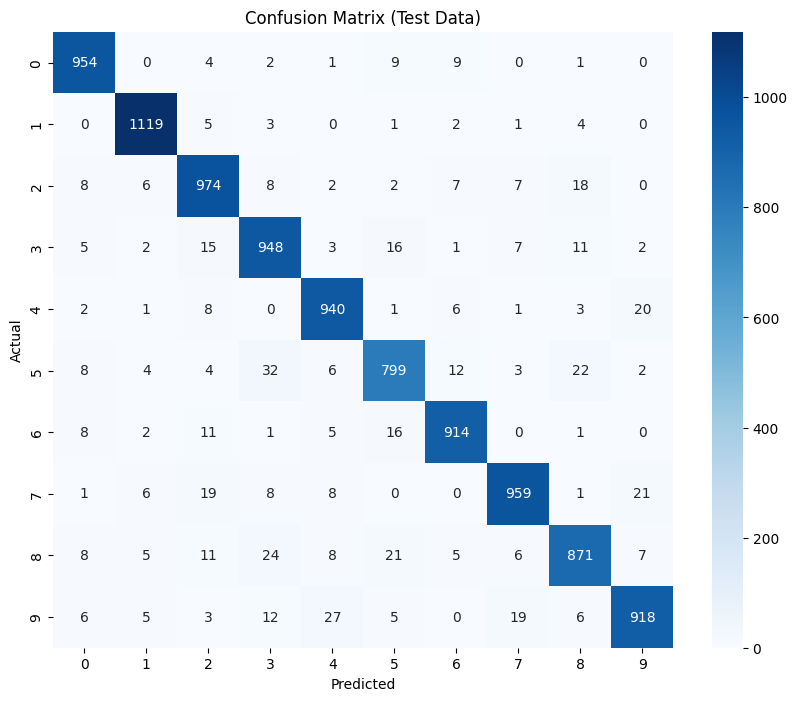

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Data)')
plt.show()

### SVM + PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=45)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
model = SVC(kernel='linear', random_state=42)
model.fit(X_train_pca, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
y_pred = model.predict(X_test_pca)

In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi: 0.9362661589337609

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.93      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.93      0.95      0.94       982
           5       0.90      0.88      0.89       892
           6       0.95      0.96      0.96       958
           7       0.95      0.93      0.94      1023
           8       0.93      0.90      0.91       966
           9       0.94      0.90      0.92      1001

    accuracy                           0.94      9979
   macro avg       0.94      0.94      0.94      9979
weighted avg       0.94      0.94      0.94      9979



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = best_model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Akurasi: 0.898
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       100
           1       0.95      0.97      0.96       100
           2       0.87      0.88      0.88       100
           3       0.89      0.91      0.90       100
           4       0.89      0.88      0.88       100
           5       0.88      0.92      0.90       100
           6       0.94      0.94      0.94       100
           7       0.87      0.78      0.82       100
           8       0.94      0.84      0.89       100
           9       0.80      0.88      0.84       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



### **Convolutional Neural Network**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
train_df = pd.read_csv('train_pixels_28_normalized.csv')
test_df = pd.read_csv('test_pixels_28_normalized.csv')

Pisahkan fitur & label

In [ ]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

In [ ]:
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

Encode label

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

 One-hot encoding

In [ ]:
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

Reshape ke (28, 28, 1)

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

Bangun model CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Latih Model

In [ ]:
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.2930 - loss: 1.7776 - val_accuracy: 0.0161 - val_loss: 14.8444
Epoch 2/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.9002 - loss: 0.3228 - val_accuracy: 0.0163 - val_loss: 18.8828
Epoch 3/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9402 - loss: 0.2026 - val_accuracy: 0.0169 - val_loss: 17.6696
Epoch 4/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.9577 - loss: 0.1425 - val_accuracy: 0.0168 - val_loss: 17.9559
Epoch 5/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9658 - loss: 0.1097 - val_accuracy: 0.0168 - val_loss: 20.3938
Epoch 6/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9715 - loss: 0.0912 - val_accuracy: 0.0169 - val_loss: 20.5638
Epoch 7/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9755 - loss: 0.0803 - val_accuracy: 0.0169 - val_loss: 22.4056
Epoch 8/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0

Evaluasi di test data

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9687 - loss: 0.5995

Test Accuracy: 0.7935


Prediksi & laporan

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
target_names = [str(c) for c in le.classes_]
print(classification_report(y_test_enc, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

           0       0.92      0.99      0.96       980
           1       0.96      1.00      0.98      1135
           2       0.89      0.98      0.94      1032
           3       0.70      0.99      0.82      1010
           4       0.58      0.99      0.73       982
           5       0.77      0.98      0.86       892
           6       0.96      0.99      0.97       958
           7       0.73      0.99      0.84      1023
           8       0.00      0.00      0.00       966
           9       0.00      0.00      0.00      1001

    accuracy                           0.79      9979
   macro avg       0.65      0.79      0.71      9979
weighted avg       0.66      0.79      0.71      9979



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

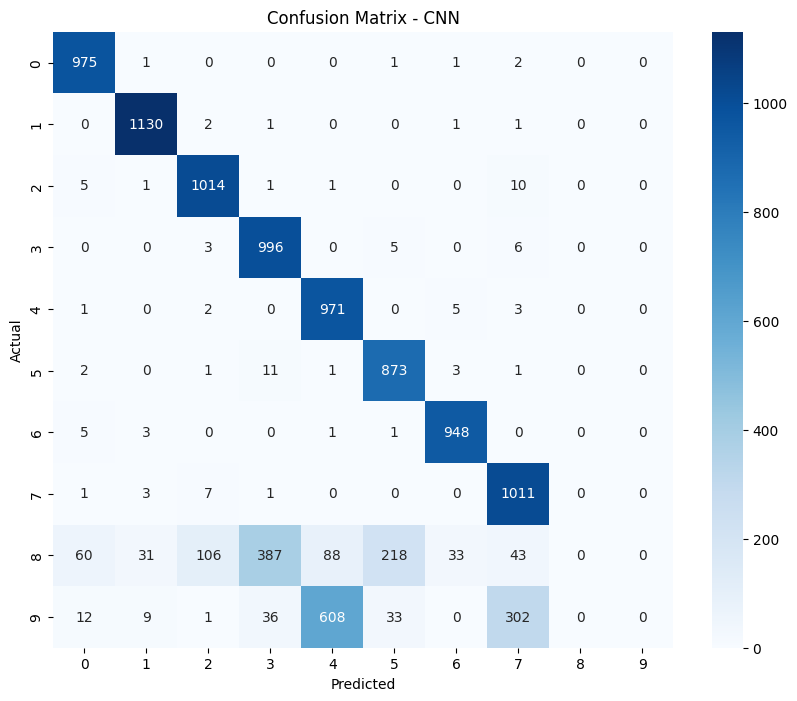

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_enc, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.show()

### CNN Sparse Categorical

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=64)

Epoch 1/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 44s 50ms/step - accuracy: 0.3388 - loss: 1.7591 - val_accuracy: 0.0080 - val_loss: 15.2844
Epoch 2/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.8809 - loss: 0.3944 - val_accuracy: 0.0082 - val_loss: 16.4480
Epoch 3/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.9229 - loss: 0.2539 - val_accuracy: 0.0085 - val_loss: 18.0382
Epoch 4/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9420 - loss: 0.1939 - val_accuracy: 0.0087 - val_loss: 17.7676
Epoch 5/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9516 - loss: 0.1688 - val_accuracy: 0.0087 - val_loss: 17.9261
Epoch 6/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.9585 - loss: 0.1413 - val_accuracy: 0.0087 - val_loss: 18.2209
Epoch 7/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9628 - loss: 0.1267 - val_accuracy: 0.0087 - val_loss: 17.5165
Epoch 8/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9649 - loss: 0.

312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


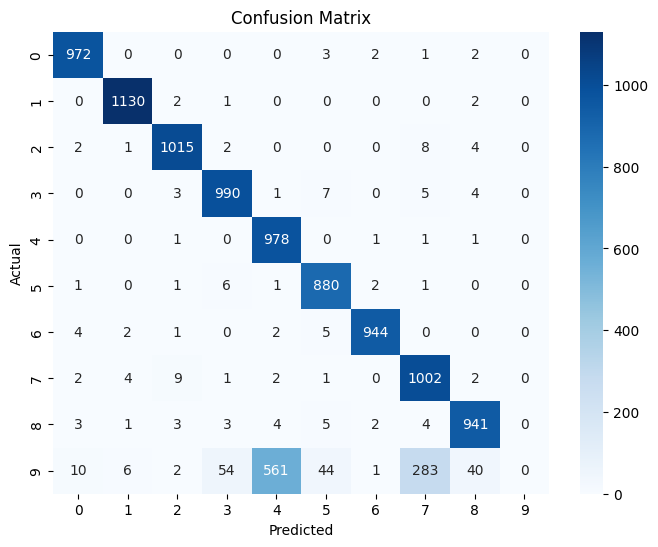

Accuracy: 0.8871


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


### CNN dengan Data Augmentation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(datagen.flow(X_train, y_train, batch_size=64),epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


939/939 ━━━━━━━━━━━━━━━━━━━━ 69s 71ms/step - accuracy: 0.3263 - loss: 1.8739 - val_accuracy: 0.8403 - val_loss: 0.5543
Epoch 2/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.6607 - loss: 1.0140 - val_accuracy: 0.9234 - val_loss: 0.2927
Epoch 3/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.7640 - loss: 0.7140 - val_accuracy: 0.9478 - val_loss: 0.1818
Epoch 4/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.8171 - loss: 0.5612 - val_accuracy: 0.9579 - val_loss: 0.1445
Epoch 5/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.8460 - loss: 0.4843 - val_accuracy: 0.9616 - val_loss: 0.1233
Epoch 6/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.8630 - loss: 0.4370 - val_accuracy: 0.9636 - val_loss: 0.1124
Epoch 7/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.8744 - loss: 0.4039 - val_accuracy: 0.9674 - val_loss: 0.1018
Epoch 8/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.8837 - loss: 0.3791 - val_accurac

312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


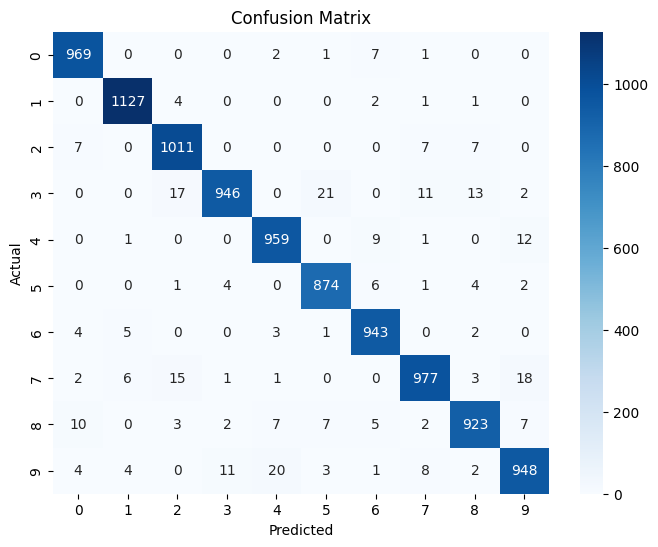

Accuracy: 0.9697


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


## **Evaluasi Model**

### **SVM**

In [ ]:
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

Akurasi: 0.9415773123559474

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.91      0.94      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.92      0.90      0.91       892
           6       0.96      0.95      0.96       958
           7       0.96      0.94      0.95      1023
           8       0.93      0.90      0.91       966
           9       0.95      0.92      0.93      1001

    accuracy                           0.94      9979
   macro avg       0.94      0.94      0.94      9979
weighted avg       0.94      0.94      0.94      9979



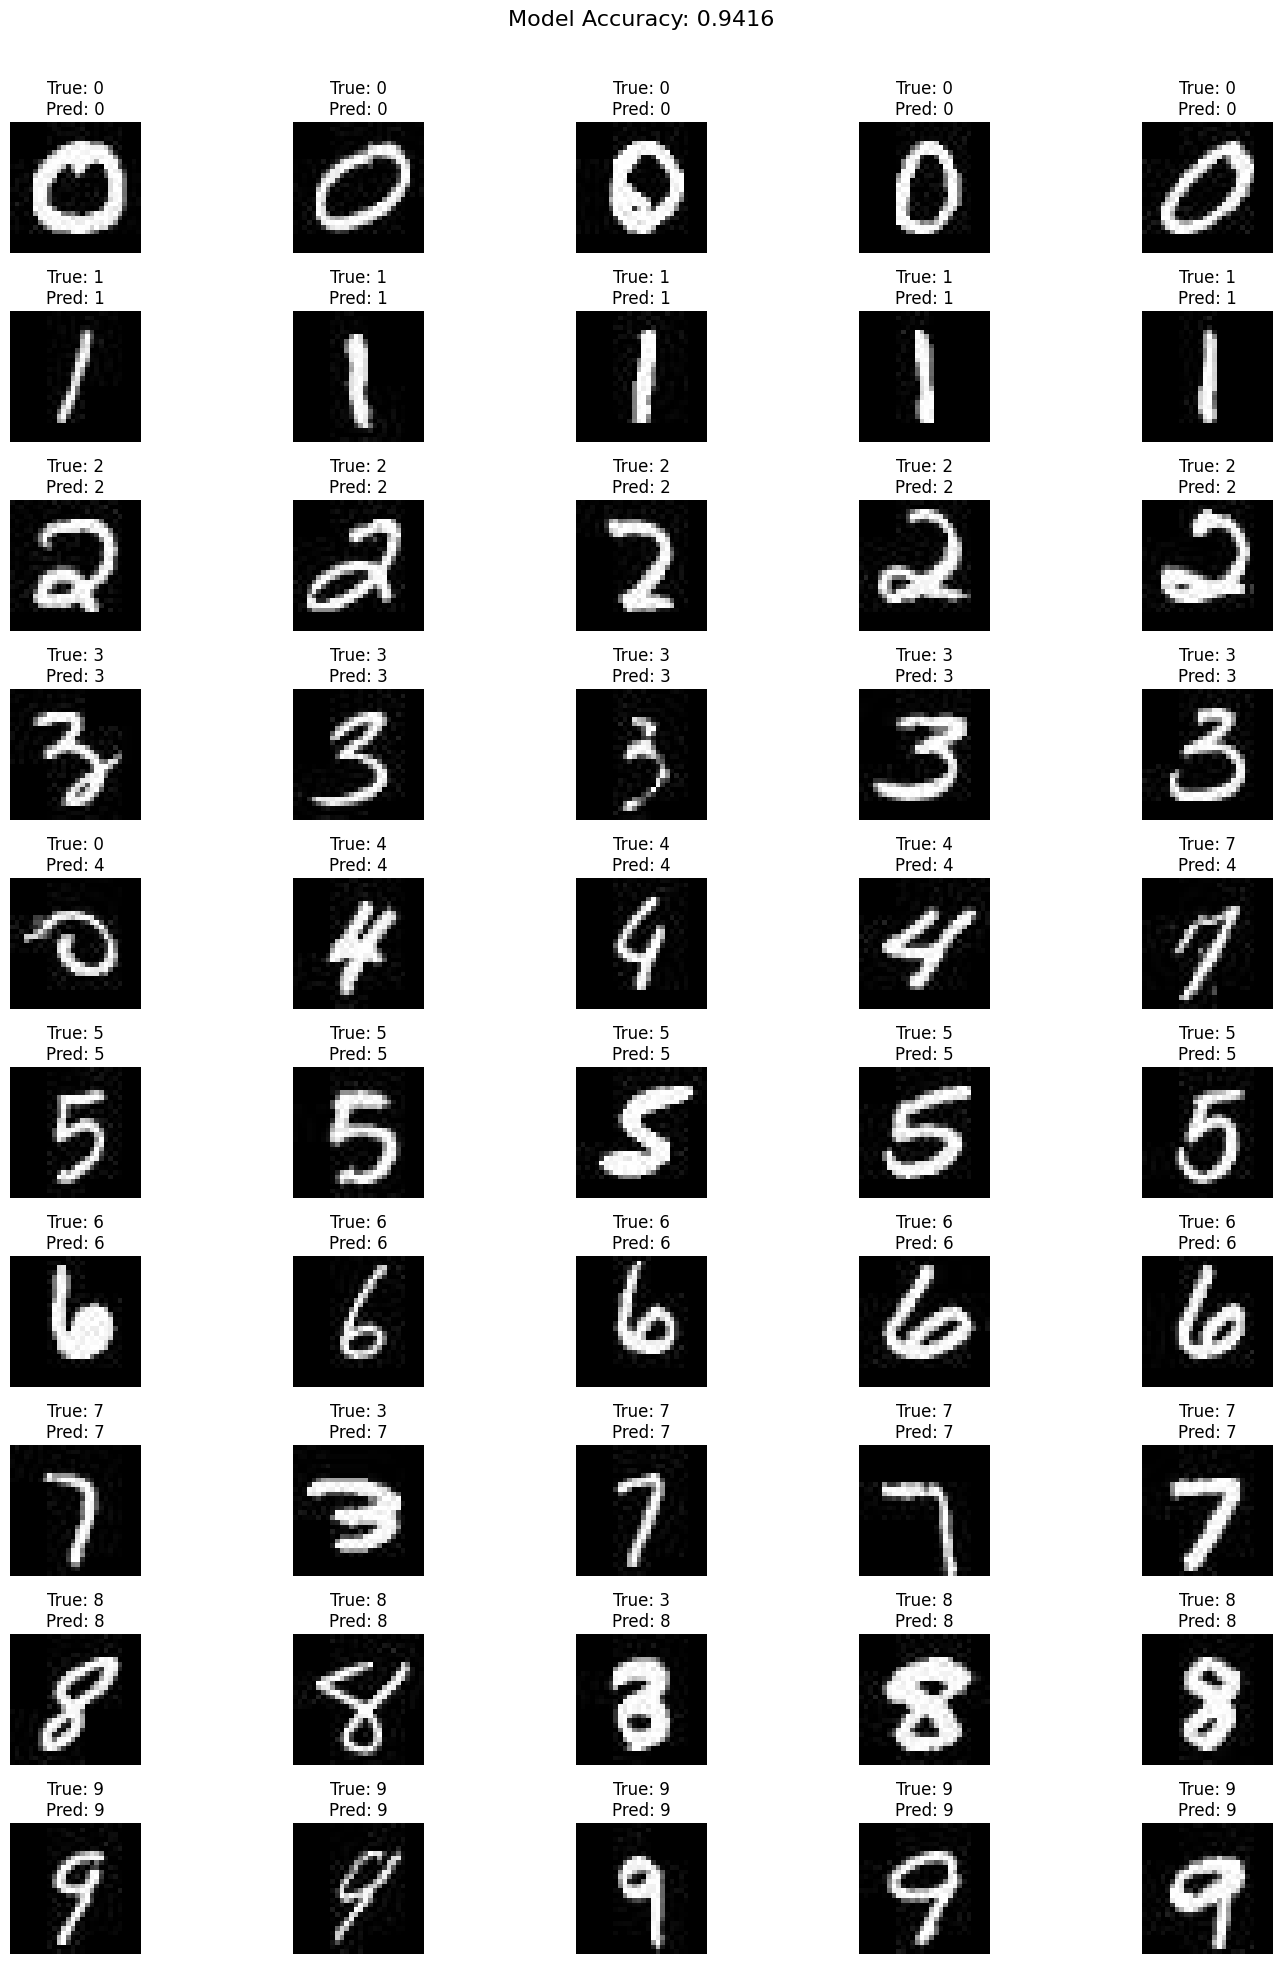

In [ ]:
# Akurasi dan laporan klasifikasi
acc = accuracy_score(y_test, y_pred)
print("Akurasi:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Ambil 5 contoh per label dari prediksi
label_examples = {}
for label in range(10):
    indices = np.where(y_pred == label)[0]
    selected_indices = random.sample(list(indices), 5) if len(indices) >= 5 else list(indices)
    label_examples[label] = selected_indices

# Visualisasi
plt.figure(figsize=(15, 20))
i = 1
for label in range(10):
    for idx in label_examples[label]:
        plt.subplot(10, 5, i)
        plt.imshow(X_test.iloc[idx].values.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"True: {y_test.iloc[idx]}\nPred: {y_pred[idx]}")
        i += 1

plt.suptitle(f"Model Accuracy: {acc:.4f}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### **CNN** #

312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Model Accuracy: 0.9697


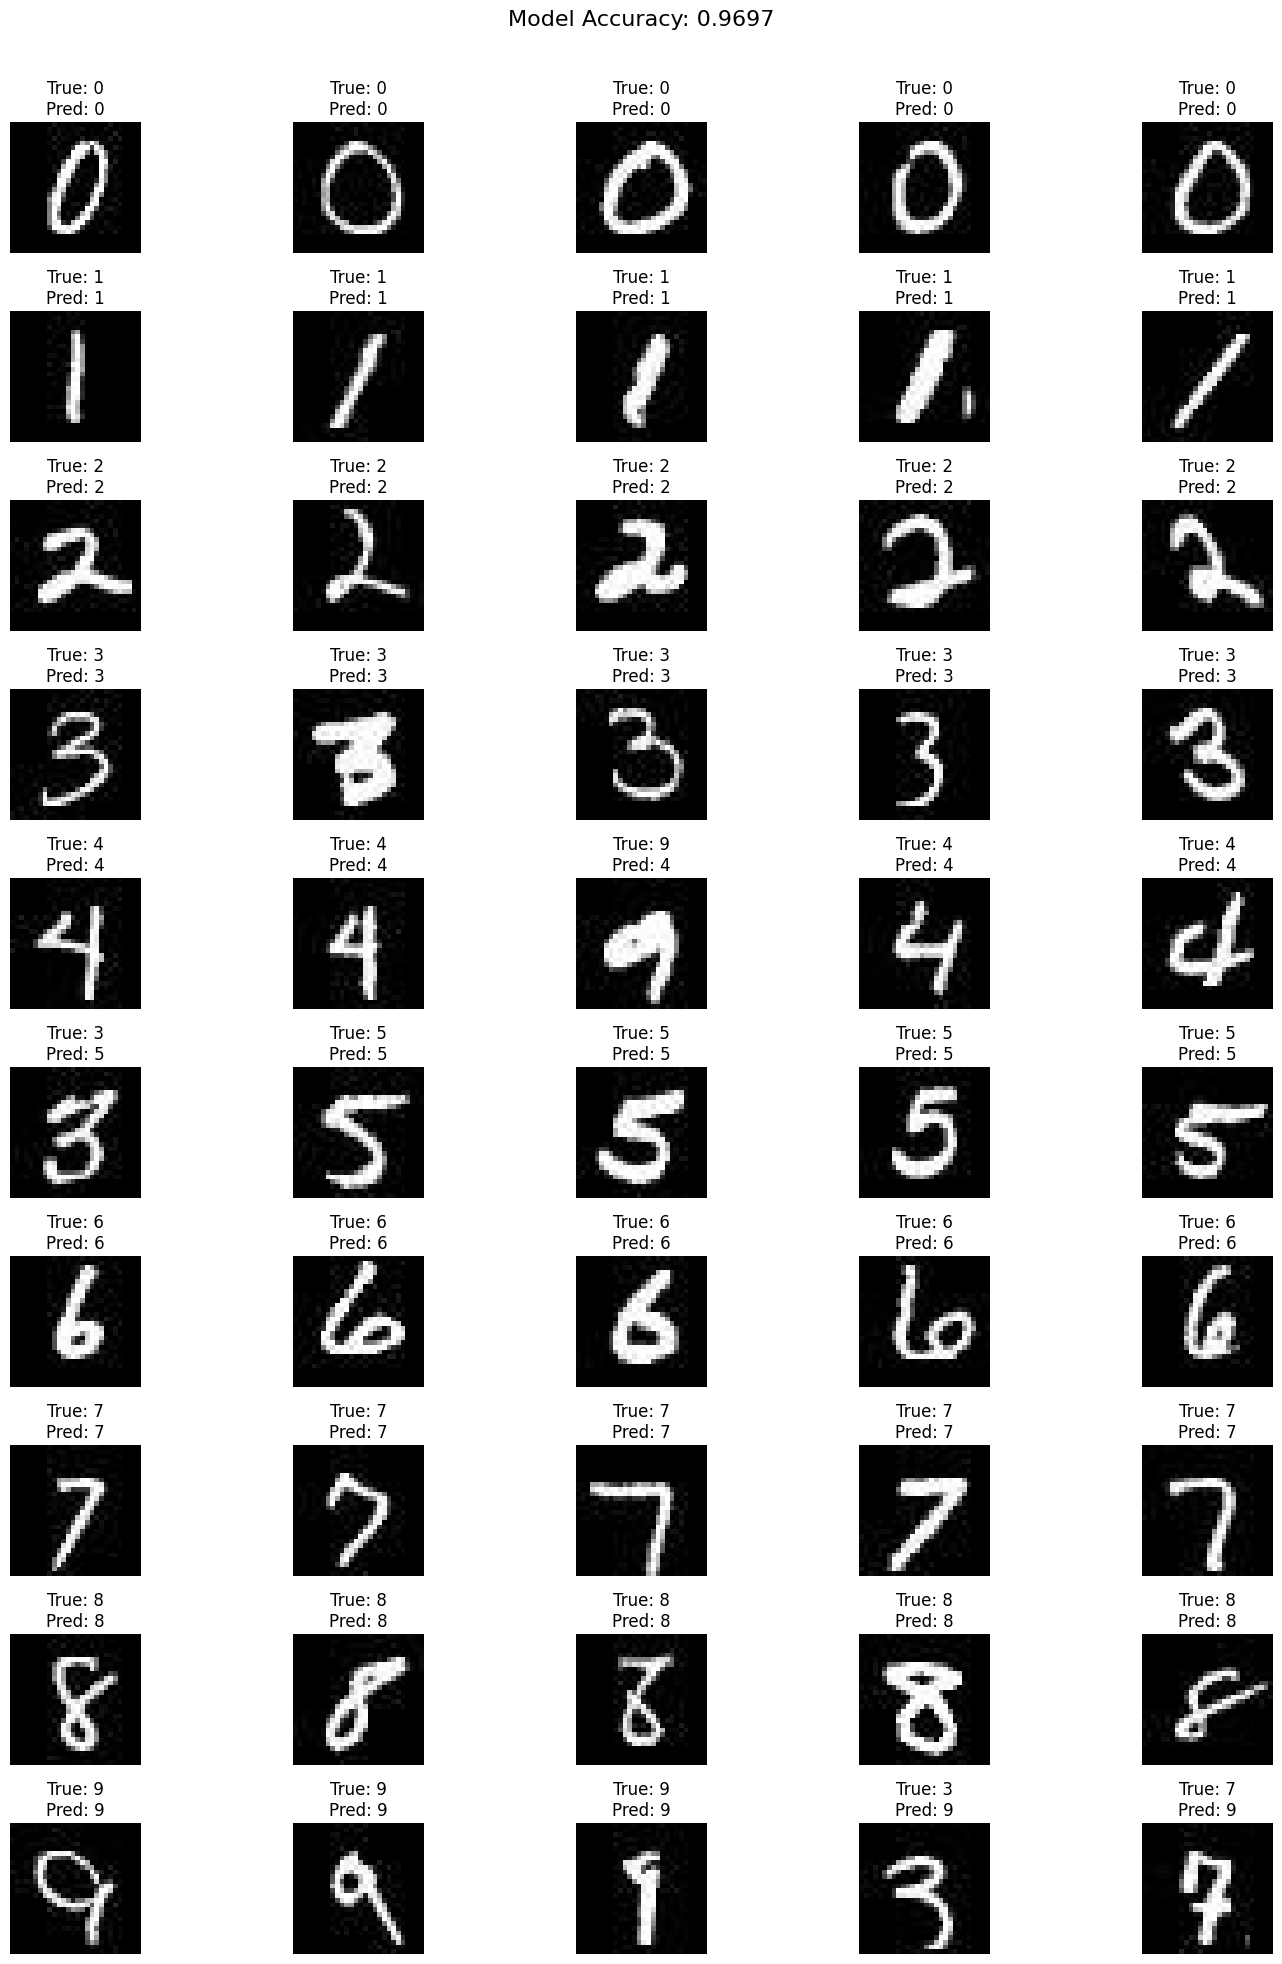

In [ ]:
# Konversi prediksi dan label ke bentuk label angka
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Hitung akurasi prediksi
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {acc:.4f}")

# Simpan index citra-citra dengan prediksi yang benar per label
import random
label_examples = {}

for label in range(10):
    indices = np.where(y_pred == label)[0]
    selected_indices = random.sample(list(indices), 5) if len(indices) >= 5 else list(indices)
    label_examples[label] = selected_indices

# Plot hasil prediksi: 5 gambar per label
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
i = 1
for label in range(10):
    for idx in label_examples[label]:
        plt.subplot(10, 5, i)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        i += 1

plt.suptitle(f"Model Accuracy: {acc:.4f}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Supaya tidak menimpa judul
plt.show()


## **Visualisasi dan Analisis Hasil**

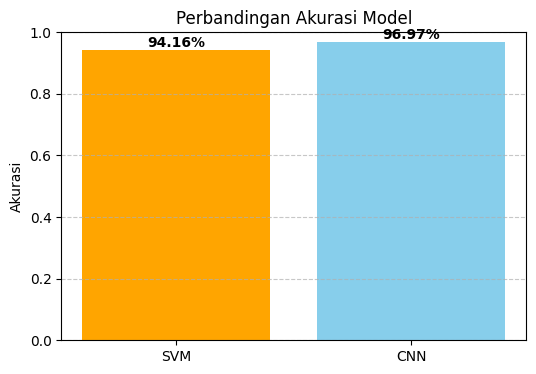

In [ ]:
import matplotlib.pyplot as plt

model_names = ['SVM', 'CNN']
accuracies = [0.9415773123559474, 0.9697]

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, accuracies, color=['orange', 'skyblue'])
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Akurasi")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan nilai akurasi di atas masing-masing bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.2%}", ha='center', fontsize=10, fontweight='bold')

plt.show()

```Berdasarkan hasil evaluasi akurasi, model SVM memperoleh akurasi sebesar 94.16%, sedangkan model CNN mencapai akurasi yang lebih tinggi yaitu 96.97%. Perbedaan ini menunjukkan bahwa CNN lebih unggul dalam mengenali pola visual pada data gambar angka, menjadikannya model yang lebih efektif untuk tugas klasifikasi citra seperti pengenalan tulisan tangan.```

```Dari sisi data, MNIST merupakan kumpulan data citra grayscale 28x28 piksel yang merepresentasikan angka tulisan tangan dari 0 hingga 9. Setiap gambar memiliki karakteristik unik, seperti perbedaan ketebalan, goresan, dan gaya penulisan individu. Insight penting yang dapat diambil adalah bahwa meskipun angka-angka terlihat sederhana bagi manusia, terdapat banyak variasi dalam penulisannya yang dapat memengaruhi hasil klasifikasi. Model yang digunakan harus mampu menggeneralisasi dari berbagai bentuk angka agar tetap akurat terhadap data baru.```

```Selain itu, model CNN mampu mengekstraksi fitur spasial dari data gambar seperti garis lengkung, ujung tajam, dan struktur lokal tanpa perlu preprocessing yang kompleks. Ini menjelaskan mengapa CNN mengungguli SVM dalam konteks ini. Insight lainnya adalah bahwa keberhasilan model klasifikasi tidak hanya bergantung pada arsitektur algoritma, tetapi juga pada kecocokan model dengan struktur data yang digunakan. Dalam kasus data visual seperti MNIST, CNN memberikan keunggulan signifikan berkat kemampuannya mengenali pola dua dimensi secara otomatis dan efisien.```